# Оганян Роберт


# Practiсe \ Howework

### Task
Build a classifier based on CIFAR100 (https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR100.html#torchvision.datasets.CIFAR100). This classifier must distinguish between bicycle, motorcycle and the background.

To this end, leverage an ImageNet-pretrained model and modify the last layer (https://pytorch.org/vision/0.8/models.html).
Use any architecture of your choice, it does not matter.

### Features
**7\10 base**: complete this task.

**+1 point**: leverage 5 augmentations (https://pytorch.org/vision/stable/transforms.html).


**+1 point**: play around with hyperparameters.


**+2 points**: say, we want to use this classifier in the wild and we need it to be stable in a dark environment.
To this end, we wanna use IR cameras with the invisible IR flashes. However, such cameras stream images in grayscale.

We want to leverage the opensource RGB datasets for this task.

=> Make a grayscale model.


### Advanced H\w: learn how to fool around with the weights as they were some usual numpy arrays
**+1 point**: say we are making a grayscale model and we want to minimize the training. Our dataset is very small, Imagenet is very large, we want to keep as much ImageNet information as possible to improve generalization. 

The first layer in the PyTorch ImageNet RGB checkpoint has 3 RGB channels, right? Modify this layer in a rule-based fashion to have 1 grayscale channel as an input and transform the features in the most correct way.

(*Spoiler alert*: the 1 input grayscale channel should be a linear combination of the 3 RGB channels)

**+2 points**: say we have some Chineese experimental on-board device that only can compute Conv3d effectively but not Conv2d. Or we just know that a Conv3d backend works faster on our target device. Or we plan that this model would accept videos in the future and we want to prepare a Conv3d backend. In short, we have our reasons to do the following.

Transform the model so that at least some Conv2d layers use a Conv3d backend leveraging the pretrained weights.#

Max points number for H\w is 10.

Deadline 8.12 23:59

## Начало

Графики я не рисовал, так как pytorch_lightning выводит метрики по эпохам на экран сам.

Забегая вперед скажу, что оценивать решение метрикой **без учета баланса классов** - неверно. С обычным акьюраси, например, у меня простейшая модель показывала 0.98 - это из-за того, что она предсказывает много бекграунда, а на самих классах мотоцикл и велосиед точность сильно, сильно меньше. 

Также для обучения нужно использовать либо weighted crossentropy, либо oversampling - weightedsampler для даталоадера

In [1]:
#!g1.1
%pip install -U -qq scikit-learn
%pip install -U -qq git+https://github.com/albumentations-team/albumentations
%pip install -U -qq typing_extensions
%pip install -U -qq torchvision==0.13.1

In [76]:
#!g1.1
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
import numpy as np
import albumentations as A
from torchvision import transforms as tt
from PIL import Image
from torch.utils.data import WeightedRandomSampler

from pytorch_lightning.callbacks import progress
from torch.nn.modules.activation import LogSoftmax
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter
import PIL

from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
#!g1.1
dataset = CIFAR100(root = 'data/', download = True)
test_dataset = CIFAR100(root = 'data/', train = False)

Files already downloaded and verified


In [23]:
#!g1.1
BICYCLE, BICYCLE_NEW = 8, 0
MOTORCYCLE, MOTORCYCLE_NEW =  48, 1
BACKGROUND_NEW = 2

Нам нужно проделать следующие шаги с датасетом:
1. Переразметить его
2. Поделить на train&val с учетом распределения классов (стратификация)
3. Посчитать вероятности классов (веса), чтобы можно было сделать даталоадер с weightedsampler (даталоадеар будет учитывать баланс классов в батчах).

In [24]:
#!g1.1
X = [el[0] for el in dataset]
y = [el[1] for el in dataset]

for idx, class_ in enumerate(y):
    if class_ == BICYCLE:
        y[idx] = BICYCLE_NEW
    elif class_ == MOTORCYCLE:
        y[idx] = MOTORCYCLE_NEW
    else:
        y[idx] = BACKGROUND_NEW
        
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
#!g1.1
X_test = [el[0] for el in test_dataset]
y_test = [el[1] for el in test_dataset]

for idx, class_ in enumerate(y_test):
    if class_ == BICYCLE:
        y_test[idx] = BICYCLE_NEW
    elif class_ == MOTORCYCLE:
        y_test[idx] = MOTORCYCLE_NEW
    else:
        y_test[idx] = BACKGROUND_NEW

Наш датасет

In [26]:
#!g1.1
class MyDataset(Dataset):
    def __init__(self, X, y, transforms = None):
        self.transforms = transforms 
        assert len(X) == len(y)
        self.X = X
        self.y = y
        
        self.weights = [] # для сэмплера
        self.count_of_elems_in_classes = dict(Counter(y))
                    
        for class_ in self.y:
            self.weights += [1.0 / self.count_of_elems_in_classes[class_]]
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

In [7]:
#!g1.1
ds_example = MyDataset(X=X_train, y=y_train)
ds_example.count_of_elems_in_classes

{2: 39200, 1: 400, 0: 400}

Как видим, у полученных данных очень плохой баланс. Поэтому будем считать weighted accuracy. Для этого посчитаем веса (они одинаковые для трейна, вала и теста, я проверил):

In [27]:
#!g1.1
WEIGHTS = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=np.array(y_train))
print(WEIGHTS)
WEIGHTS = torch.tensor(WEIGHTS, dtype=torch.float).to(device)

[33.33333333 33.33333333  0.34013605]


В качестве модели возьму предобученную efficientnet_b4. Семейства этих моделей хороши тем, что соблюден баланс глубины, ширины и разрешающей способности нейронной сети, что предотвращает переобучение и решает проблему затухающих градиентов

## Approach 1. Simple model with weighted cross-entropy


Попробуем тупую модель без перебора гиперпараметров, без разморозки предобученной модели, без аугментаций и преобразований изображения

In [28]:
#!g1.1
class MyModel_1(pl.LightningModule):    
    
    def __init__(self, num_classes=3, **optimizer_hyperparams):
        super().__init__()
              
        self.model = torchvision.models.efficientnet_b4(pretrained=True, progress = True)
        self.optimizer_hyperparams = optimizer_hyperparams

        in_feat = self.model.classifier[1].in_features
        out_feat = self.model.classifier[1].out_features
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(in_features=in_feat, out_features=out_feat),
            nn.BatchNorm1d(out_feat),
            nn.ReLU(),
            nn.Linear(in_features=out_feat, out_features=num_classes)
        )
        
        for param in self.model.classifier.parameters():
            param.requires_grad = True
                    
        self.training_params_num = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
 
    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

    def cross_entropy_loss(self, logits, labels):
#         return F.nll_loss(logits, labels) # if it was balanced
        return F.nll_loss(logits, labels, weight=WEIGHTS, reduction='mean')
    
    def configure_optimizers(self):    
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return [optimizer]

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)

        logs = {'train_loss': loss}
#         acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0] # if it was balanced
        y_pred = logits.argmax(dim=1).detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        acc = torch.FloatTensor([balanced_accuracy_score(y_pred, y)]).to(device)
        
        self.log('train_acc', acc, on_step=True, prog_bar=True)
        self.log('train_loss', loss, on_step=True, prog_bar=True)

        return {'loss': loss, 'log': logs}

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        
       #         acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0] # if it was balanced
        y_pred = logits.argmax(dim=1).detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        acc = torch.FloatTensor([balanced_accuracy_score(y_pred, y)]).to(device)

        self.log('val_loss', loss, on_step=True, on_epoch=False)
        self.log('val_acc', acc, on_step=True, on_epoch=False)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        
        #         acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0] # if it was balanced
        y_pred = logits.argmax(dim=1).detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        acc = torch.FloatTensor([balanced_accuracy_score(y_pred, y)]).to(device)

        self.log('test_loss', loss, on_step=True, on_epoch=False)
        self.log('test_acc', acc, on_step=True, on_epoch=False)

        return {'test_loss': loss, 'test_acc': acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        print('Accuracy: ', round(float(avg_acc), 3))
        self.log('val_acc', avg_acc, on_epoch=True, on_step=False)
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        return {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
        self.log('test_acc', avg_acc, on_epoch=True, on_step=False)
        return {'test_loss': avg_loss, 'test_acc': avg_acc, 'log': tensorboard_logs}

In [11]:
#!g1.1
ds_train = MyDataset(X=X_train, y=y_train, transforms = tt.Compose([tt.ToTensor()]))
ds_val = MyDataset(X=X_val, y=y_val, transforms =  tt.Compose([tt.ToTensor()]))
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=8)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=8)

model = MyModel_1(num_classes=3)
trainer = pl.Trainer(max_epochs=20, gpus=1, log_every_n_steps=5)
trainer.fit(model, dl_train, dl_val)

ds_test = MyDataset(X=X_test, y=y_test, transforms =  tt.Compose([tt.ToTensor()]))
dl_test = DataLoader(ds_test, batch_size=128, num_workers=8)
trainer.test(model, dl_test)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
1.8 M     Trainable params
17.5 M    Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Accuracy:  0.984
Accuracy:  0.351
Accuracy:  0.351
Accuracy:  0.35
Accuracy:  0.359
Accuracy:  0.356
Accuracy:  0.367
Accuracy:  0.365
Accuracy:  0.363
Accuracy:  0.361
Accuracy:  0.359
Accuracy:  0.359
Accuracy:  0.367
Accuracy:  0.36
Accuracy:  0.364
Accuracy:  0.36
Accuracy:  0.36
Accuracy:  0.369
Accuracy:  0.369
Accuracy:  0.356
Accuracy:  0.359

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.35797855257987976}
--------------------------------------------------------------------------------



[{'test_acc': 0.35797855257987976}]

Получили взвешенную точность 0.357. Будем улучшать

## Approach 2. Разморозка модели + разные лернинг рейты

Вообще свертки устроены таким образом, что чем глубже сеть, тем более локальные паттерны находит модель. Исходя из этого факта, можно попробовать разморозить не всю сеть, а только последние свертки. Однако в предыдущей попытке получилась очень низкая точность, поэтому я разморожу вообще всю сеть

Получается, что мы дообучиваем слои модели и учим с нуля классификатор. В таком случае нам нужен лернинг рейт для классификатора больше, чем для backbone.

In [29]:
#!g1.1
class MyModel_2(MyModel_1):    
    
    def __init__(self, num_classes=3, **optimizer_hyperparams):
        super().__init__(num_classes=num_classes, **optimizer_hyperparams)
        
        for param in self.model.parameters():
            param.requires_grad = True
                    
        self.training_params_num = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
 
    
    def configure_optimizers(self):        
        
        parameters = [{'params': [p for n, p in self.model.features.named_parameters()],
                       'lr': 1e-3}]
        
        parameters += [{'params': [p for n, p in self.model.classifier.named_parameters()],
                        'lr': 5e-3}]
    
        optimizer = torch.optim.Adam(parameters)
        return [optimizer]


In [17]:
#!g1.1
model2 = MyModel_2(num_classes=3)
trainer = pl.Trainer(max_epochs=20, gpus=1, log_every_n_steps=5)
trainer.fit(model2, dl_train, dl_val)

ds_test = MyDataset(X=X_test, y=y_test, transforms =  tt.Compose([tt.ToTensor()]))
dl_test = DataLoader(ds_test, batch_size=128, num_workers=8)
trainer.test(model2, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy:  0.333
Accuracy:  0.513
Accuracy:  0.374
Accuracy:  0.393
Accuracy:  0.392
Accuracy:  0.396
Accuracy:  0.394
Accuracy:  0.388
Accuracy:  0.408
Accuracy:  0.403

Accuracy:  0.389
Accuracy:  0.401
Accuracy:  0.415
Accuracy:  0.411
Accuracy:  0.425
Accuracy:  0.392
Accuracy:  0.43
Accuracy:  0.441
Accuracy:  0.459
Accuracy:  0.508
Accuracy:  0.46

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.44075483083724976}
--------------------------------------------------------------------------------



[{'test_acc': 0.44075483083724976}]

Уже лучше!

## Approach 3. Перебор гиперпараметров

Честно говоря, ни разу не писал код для перебора гиперпараметров для нейросети (только вручную разными запусками). Не уверен, что для нейросетей есть аналог гридсерча классических моделей машинного обучения, поэтому придется писать вручную

In [30]:
#!g1.1
class MyModel_3(MyModel_2):    
    
    def __init__(self, num_classes=3, **optimizer_hyperparams):
        super().__init__(num_classes=num_classes, **optimizer_hyperparams)     
    
    def configure_optimizers(self):        
        
        parameters = [{'params': [p for n, p in self.model.features.named_parameters()],
                       'lr': self.optimizer_hyperparams['lr']['features']}]
        
        parameters += [{'params': [p for n, p in self.model.classifier.named_parameters()],
                        'lr': self.optimizer_hyperparams['lr']['classifier']}]
    
        optimizer = torch.optim.Adam(parameters, weight_decay=self.optimizer_hyperparams['weight_decay'])
        return [optimizer]


In [18]:
#!g1.1
lrs_features = [1e-4, 1e-3, 1e-2]
lrs_classifier = [5e-4, 5e-3, 5e-2]
weight_decays = [5e-3, 5e-4, 5e-5]

ds_train = MyDataset(X=X_train, y=y_train, transforms = tt.Compose([tt.ToTensor()]))
ds_val = MyDataset(X=X_val, y=y_val, transforms =  tt.Compose([tt.ToTensor()]))
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=8)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=8)
ds_test = MyDataset(X=X_test, y=y_test, transforms =  tt.Compose([tt.ToTensor()]))
dl_test = DataLoader(ds_test, batch_size=128, num_workers=8)



for i in range(len(lrs_features)):
    for j in range(len(weight_decays)):
        lr_feature = lrs_features[i]
        lr_classifier = lrs_classifier[i]
        weight_decay = weight_decays[j]
        
        params = {'lr': {'features': lr_feature,
                        'classifier': lr_classifier},
                 'weight_decay': weight_decay}
        
        model_gs = MyModel_3(num_classes=3, **params)
        trainer = pl.Trainer(max_epochs=5, gpus=1, log_every_n_steps=5)
        trainer.fit(model_gs, dl_train, dl_val)

        res = trainer.test(model_gs, dl_test)
        print(f'Test acc for {lr_feature=}, {lr_classifier=}, {weight_decay=} is ', res[0]['test_acc'])
        

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, us

Accuracy:  0.327
Accuracy:  0.356
Accuracy:  0.383
Accuracy:  0.438
Accuracy:  0.398
Accuracy:  0.4

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.37390977144241333}
--------------------------------------------------------------------------------

Test acc for lr_feature=0.0001, lr_classifier=0.0005, weight_decay=0.005 is  0.37390977144241333
Accuracy:  0.008
Accuracy:  0.363
Accuracy:  0.371
Accuracy:  0.381
Accuracy:  0.373
Accuracy:  0.371

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3633992373943329}
--------------------------------------------------------------------------------

Test acc for lr_feature=0.0001, lr_classifier=0.0005, weight_decay=0.0005 is  0.3633992373943329
Accuracy:  0.006
Accuracy:  0.351
Accuracy:  0.367
Accuracy:  0.394
Accuracy:  0.399
Accuracy:  0.372

------------------------------------------------------

В дальнейшем будем брать следующие гиперпараметры lr_feature=0.0001, lr_classifier=0.0005, weight_decay=0.005


## Approach 4. Аугментация без изменения размера картинки

Можно много аугментация написать вручную, но в торче есть AutoAugmentPolicy.IMAGENET, который сам применяет десятки различных аугментаций случайным образом.

In [54]:
#!g1.1
MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]


TrainAugmetation = tt.Compose([
    tt.AutoAugment(tt.AutoAugmentPolicy.IMAGENET),
    tt.RandomRotation(5),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(mean=MEAN, std=STD)
])

TestTransform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(mean=MEAN, std=STD)
])

In [56]:
#!g1.1
params = {'lr': {'features': 1e-4,
                        'classifier': 5e-4},
                 'weight_decay': 5e-3}

ds_train = MyDataset(X=X_train, y=y_train, transforms = TrainAugmetation)
ds_val = MyDataset(X=X_val, y=y_val, transforms =  TestTransform)
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=8)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=8)

model3 = MyModel_3(num_classes=3, **params)
trainer = pl.Trainer(max_epochs=10, gpus=1, log_every_n_steps=5)
trainer.fit(model3, dl_train, dl_val)

ds_test = MyDataset(X=X_test, y=y_test, transforms =  TestTransform)
dl_test = DataLoader(ds_test, batch_size=128, num_workers=8)
trainer.test(model3, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)


Accuracy:  0.0


Accuracy:  0.365



Accuracy:  0.379


Accuracy:  0.41


Accuracy:  0.414


Accuracy:  0.375


Accuracy:  0.403


Accuracy:  0.382


Accuracy:  0.381


Accuracy:  0.444


Accuracy:  0.411



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3955180048942566}
--------------------------------------------------------------------------------



[{'test_acc': 0.3955180048942566}]

Результат не очень. Попробуем еще

## Approach 5. Аугментация с изменением размера картинки

Сначала я хотел применить похожие трансформации, которые применялись к картинкам при обучении efficient_b4, но разница в размерах слишком большая... (380 против 32). Поэтому просто попробуем ресайзнуть к 128

In [57]:
#!g1.1

RESIZE_SIZE = 128

MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]


TrainAugmetation1 = tt.Compose([
    tt.Resize(RESIZE_SIZE, interpolation=PIL.Image.BICUBIC),
    tt.AutoAugment(tt.AutoAugmentPolicy.IMAGENET),
    tt.RandomRotation(5),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(mean=MEAN, std=STD)
])

TestTransform1 = tt.Compose([
    tt.Resize(RESIZE_SIZE, interpolation=PIL.Image.BICUBIC),
    tt.ToTensor(),
    tt.Normalize(mean=MEAN, std=STD)
])

In [59]:
#!g1.1
params = {'lr': {'features': 1e-4,
                        'classifier': 5e-4},
                 'weight_decay': 5e-3}
ds_train = MyDataset(X=X_train, y=y_train, transforms = TrainAugmetation1)
ds_val = MyDataset(X=X_val, y=y_val, transforms =  TestTransform1)
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=8)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=8)

model4 = MyModel_3(num_classes=3, **params)
trainer = pl.Trainer(max_epochs=10, gpus=1, log_every_n_steps=5)
trainer.fit(model4, dl_train, dl_val)

ds_test = MyDataset(X=X_test, y=y_test, transforms =  TestTransform1)
dl_test = DataLoader(ds_test, batch_size=64, num_workers=8)
trainer.test(model4, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)


Accuracy:  0.171


Accuracy:  0.476


Accuracy:  0.667


Accuracy:  0.588


Accuracy:  0.637


Accuracy:  0.682


Accuracy:  0.702


Accuracy:  0.825


Accuracy:  0.864


Accuracy:  0.817


Accuracy:  0.743


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7394039630889893}
--------------------------------------------------------------------------------



[{'test_acc': 0.7394039630889893}]

Мы определенно смогли улучшить взвешенную точность. 

Теперь попробуем другой подход: возьмем обычную кроссэнтропию, но при обучении батчи будут сбалансированными (oversampling) путем добавления weightedsampler в даталоадер


## Approach 6. Weighted Sampler + normal cross entropy

In [36]:
#!g1.1
class MyModel_4(MyModel_3):    
    
    def __init__(self, num_classes=3, **optimizer_hyperparams):
        super().__init__(num_classes=num_classes, **optimizer_hyperparams)     
        
        
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels) # if it was balanced


In [50]:
#!g1.1
ds_train = MyDataset(X=X_train, y=y_train, transforms = TrainAugmetation1)
ds_val = MyDataset(X=X_val, y=y_val, transforms =  TestTransform1)

weights_sampler = torch.DoubleTensor(ds_train.weights)                                       
sampler = WeightedRandomSampler(weights_sampler, len(weights_sampler)) 

dl_train = DataLoader(ds_train, batch_size=64, num_workers=8, sampler=sampler)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=8)

In [42]:
#!g1.1
for i, batch in enumerate(dl_train):
    print(Counter(batch[1].detach().cpu().numpy()))
    if i == 5:
        break

Counter({1: 23, 2: 21, 0: 20})
Counter({2: 25, 0: 21, 1: 18})
Counter({0: 26, 1: 23, 2: 15})
Counter({2: 23, 0: 22, 1: 19})
Counter({1: 25, 0: 23, 2: 16})
Counter({1: 26, 2: 22, 0: 16})


In [49]:
#!g1.1
params = {'lr': {'features': 1e-4,
                        'classifier': 5e-4},
                 'weight_decay': 5e-3}

In [51]:
#!g1.1
model5 = MyModel_4(num_classes=3, **params)
trainer = pl.Trainer(max_epochs=10, gpus=1, log_every_n_steps=5)
trainer.fit(model5, dl_train, dl_val)

ds_test = MyDataset(X=X_test, y=y_test, transforms =  TestTransform1)
dl_test = DataLoader(ds_test, batch_size=64, num_workers=8)
trainer.test(model5, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)


Accuracy:  0.984


Accuracy:  0.524


Accuracy:  0.72


Accuracy:  0.786


Accuracy:  0.841


Accuracy:  0.865


Accuracy:  0.925


Accuracy:  0.909


Accuracy:  0.917


Accuracy:  0.88


Accuracy:  0.814



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8245165348052979}
--------------------------------------------------------------------------------



[{'test_acc': 0.8245165348052979}]

И это логичный результат, ведь предобученная сетка училась на картинках 380x380. Значит и обучать её надо на более близком к этому разрешению. Думаю, если ресайзить больше, чем к 128, результат будет еще лучше (но это не точно)

На этом этапе мы с уверенностью можем сказать, что нам удалось улучшить модель с помощью аугментаций и перебора гиперпараметров. Также можно улучшить модель, получить 92%+ точность следующими способами:
1. Добавить шедулер, например ReduceOnPlato. Он уменьшет lr в factor раз, если выбранная метрика не улучшается в течение patience эпох

```
optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                   mode='min', 
                                                                   factor=0.25, 
                                                                   patience=3, 
                                                                   verbose=True)
        
lr_dict = {
           "scheduler": lr_scheduler,
           "interval": "epoch",
           "frequency": 1,
           "monitor": "val_loss"
        } 
        
return [optimizer], [lr_dict]
```

2. Увеличить количество эпох и добавить коллбеки.

```
## Save the model periodically by monitoring a quantity.
MyModelCheckpoint = ModelCheckpoint(dirpath='./check_points',
                                    filename='model',
                                    monitor='val_loss', 
                                    mode='min', 
                                    save_top_k=3)

## Monitor a metric and stop training when it stops improving.
MyEarlyStopping = EarlyStopping(monitor = "val_loss",
                                mode = "min",
                                patience = 8,
                                verbose = True)
                                
```

Но мне лень это делать, это же не конкурс, чтобы побеждать. На данный момент задание выполнено на 7 баллов + 1 за аугментации + 1 за перебор гиперпараметров

## Модель для одноканальных (серых) изображений

convert('L') переводит картинку из ргб в серое. convert('RGB') переводит обратно в трехканальное (три одинаковых канала). Таким образом нам не нужно менять сетку, просто нужно дообучить её

In [67]:
#!g1.1
def to_gray_scale_three_channel(img):
    return img.convert('L').convert('RGB')

torch.Size([3, 32, 32])


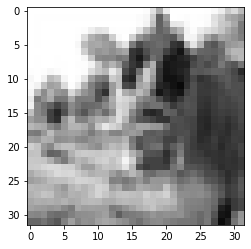

In [74]:
#!g1.1
print(tt.ToTensor()(to_gray_scale_three_channel(X[0])).shape)
plt.imshow(tt.Compose([to_gray_scale_three_channel])(X[0]))

In [83]:
#!g1.1
RESIZE_SIZE = 128

MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]


TrainAugmetation2 = tt.Compose([
    tt.Resize(RESIZE_SIZE, interpolation=PIL.Image.BICUBIC),
    to_gray_scale_three_channel,
    tt.RandomRotation(5),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(mean=MEAN, std=STD)
])

TestTransform2 = tt.Compose([
    to_gray_scale_three_channel,
    tt.Resize(RESIZE_SIZE, interpolation=PIL.Image.BICUBIC),
    tt.ToTensor(),
    tt.Normalize(mean=MEAN, std=STD)
])

In [84]:
#!g1.1
params = {'lr': {'features': 1e-4,
                        'classifier': 5e-4},
                 'weight_decay': 5e-3}

ds_train = MyDataset(X=X_train, y=y_train, transforms = TrainAugmetation2)
ds_val = MyDataset(X=X_val, y=y_val, transforms =  TestTransform2)

weights_sampler = torch.DoubleTensor(ds_train.weights)                                       
sampler = WeightedRandomSampler(weights_sampler, len(weights_sampler)) 

dl_train = DataLoader(ds_train, batch_size=64, num_workers=8, sampler=sampler)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=8)

model5 = MyModel_3(num_classes=3, **params)
trainer = pl.Trainer(max_epochs=10, gpus=1, log_every_n_steps=5)
trainer.fit(model5, dl_train, dl_val)

ds_test = MyDataset(X=X_test, y=y_test, transforms =  TestTransform2)
dl_test = DataLoader(ds_test, batch_size=64, num_workers=8)
trainer.test(model5, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 19.3 M
---------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.386    Total estimated model params size (MB)


Accuracy:  0.495


Accuracy:  0.348


Accuracy:  0.351


Accuracy:  0.353


Accuracy:  0.354


Accuracy:  0.351


Accuracy:  0.351


Accuracy:  0.348


Accuracy:  0.356


Accuracy:  0.352


Accuracy:  0.353


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.35134145617485046}
--------------------------------------------------------------------------------



[{'test_acc': 0.35134145617485046}]

Сетка практически не обучилась :(. Наверное, дело в данных. Картинка слишком маленькая, чтобы нейросетка могла находить внятные паттерны границ, а приведя Rgb к черно-белому формату, мы потеряли необходимую информацию